# Detecção e Redução de Fraudes no Setor Financeiro

## Desafio Classificação - NVIDIA

### Resolução por Caroline Dalmazzo

### Base de Dados

A base de dados que será utilizada para o desenvolvimento deste desafio contém aproximadamente 6,3 milhões de transações. Os dados contidos nesta base de dados são simulados, não sendo transações reais efetuadas em algum sistema financeiro, e compreendem 30 dias. Estas transações podem ser de diferentes tipos e representam transações executadas via mobile devices. As features contidas nesta base de dados são:

*   step - Passo: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 (30 dias);
*   type - Tipo: tipo de transação (depósito, saque, débito, pagamento e transferência);
*   amount - Quantia: total que foi transacionado;
*   nameOrig - ClienteOrigem: cliente que iniciou a transação;
*   oldbalanceOrg - SaldoInicialOrigem: saldo da conta de origem antes da transação;
*   newbalanceOrig - SaldoFinalOrigem: saldo da conta de origem após a transação;
*   nameDest - ClienteDestino: cliente de destino da transação;
*   oldbalanceDest - SaldoInicialDestino: saldo da conta de destino antes da transação;
*   newbalanceDest - SaldoFinalDestino: saldo da conta de destino após a transação;
*   isFraud - ÉFraude: flag que define se a transação é fraudulenta ou não. Nesta simulação o objetivo da fraude é assumir a conta do usuário, esvaziá-la transferindo para outra conta e então sacando o dinheiro.
*   isFlaggedFraud - SinalizadaComoFraude: automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

Importando bibliotecas que serão utilizadas:

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados em cpu
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x) # evita que o pandas utilize notação científica

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# Bibliotecas processamento
from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import accuracy_score, recall_score,f1_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report

# Bibliotecas de Rebalanceamento
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE

# Classifier Models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Feature importance
from sklearn.inspection import permutation_importance

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fraud_detection_dataset.csv')

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1,0
4,1,PAYMENT,11668.14000,C2048537720,41554.00000,29885.86000,M1230701703,0.00000,0.00000,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Avaliação dos Dados

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99], include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00000,6362620,6362620.00000,6362620,6362620.00000,6362620.00000,6362620,6362620.00000,6362620.00000,6362620.00000,6362620.00000
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,243.39725,NaN,179861.90355,NaN,833883.10407,855113.66858,NaN,1100701.66652,1224996.39820,0.00129,0.00000
std,142.33197,NaN,603858.23146,NaN,2888242.67304,2924048.50295,NaN,3399180.11299,3674128.94212,0.03590,0.00159
min,1.00000,NaN,0.00000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000
1%,9.00000,NaN,449.46760,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000
5%,16.00000,NaN,2224.09950,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000
25%,156.00000,NaN,13389.57000,NaN,0.00000,0.00000,NaN,0.00000,0.00000,0.00000,0.00000


### EDA

In [10]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [11]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [13]:
df['isFraud'].value_counts(normalize=True)*100

0   99.87092
1    0.12908
Name: isFraud, dtype: float64

In [12]:
16*100/8213

0.19481310118105444

O dataset é extremamente desbalanceado, com apenas 0.12% dos dados representando fraudes. Dentre as fraudes, apenas 0.2% delas foram automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

In [14]:
df_frauds = df[df['isFraud']==1]
df_normal = df[df['isFraud']==0]

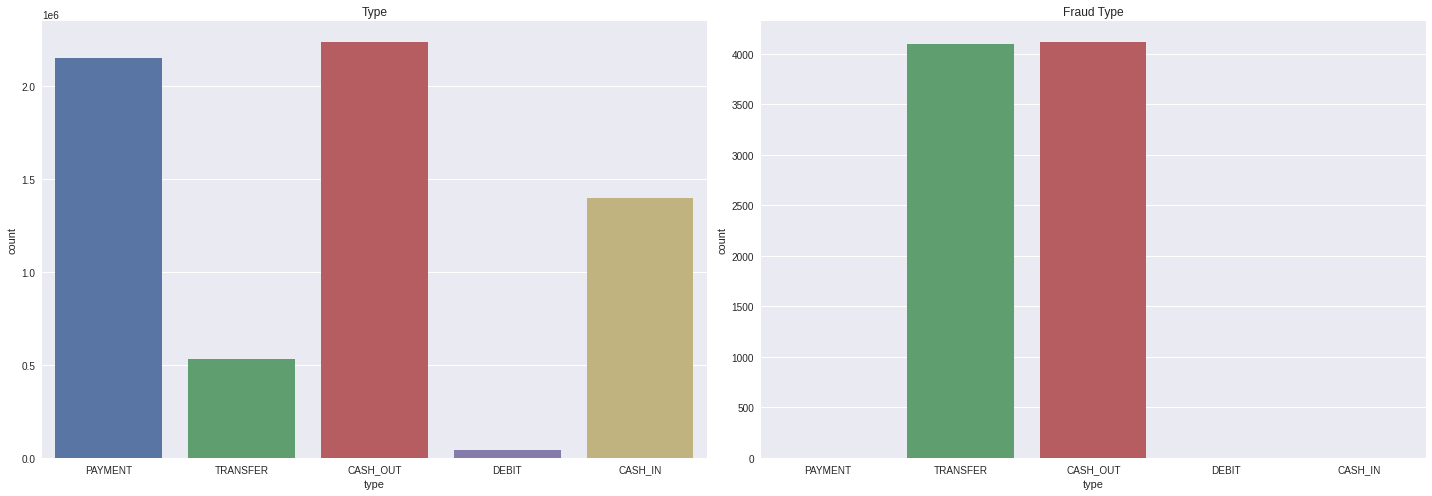

In [15]:
fig, axes = plt.subplots(1,2,figsize=(20,7)) 

sns.countplot(data = df, ax=axes[0], x = 'type', order = ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'])
axes[0].set_title('Type')

sns.countplot(data = df_frauds, ax=axes[1], x='type', order = ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'])
axes[1].set_title('Fraud Type')

plt.tight_layout()
plt.show()   


Só existem fraudes identificadas dos tipos transfer e cash out.

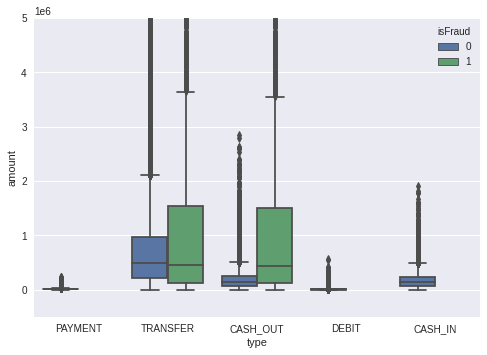

In [16]:
ax = sns.boxplot(data = df, x='type', y='amount', hue='isFraud')
ax.set_ylim([-500000, 5000000])
plt.show()

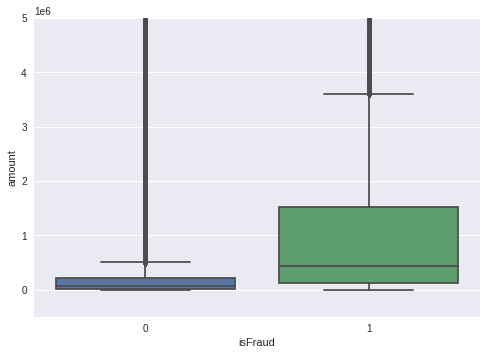

In [17]:
ax = sns.boxplot(data = df, x='isFraud', y='amount')
ax.set_ylim([-500000, 5000000])
plt.show()

Fraudes tem, em geral, valores mais altos que os valores de transações usuais.

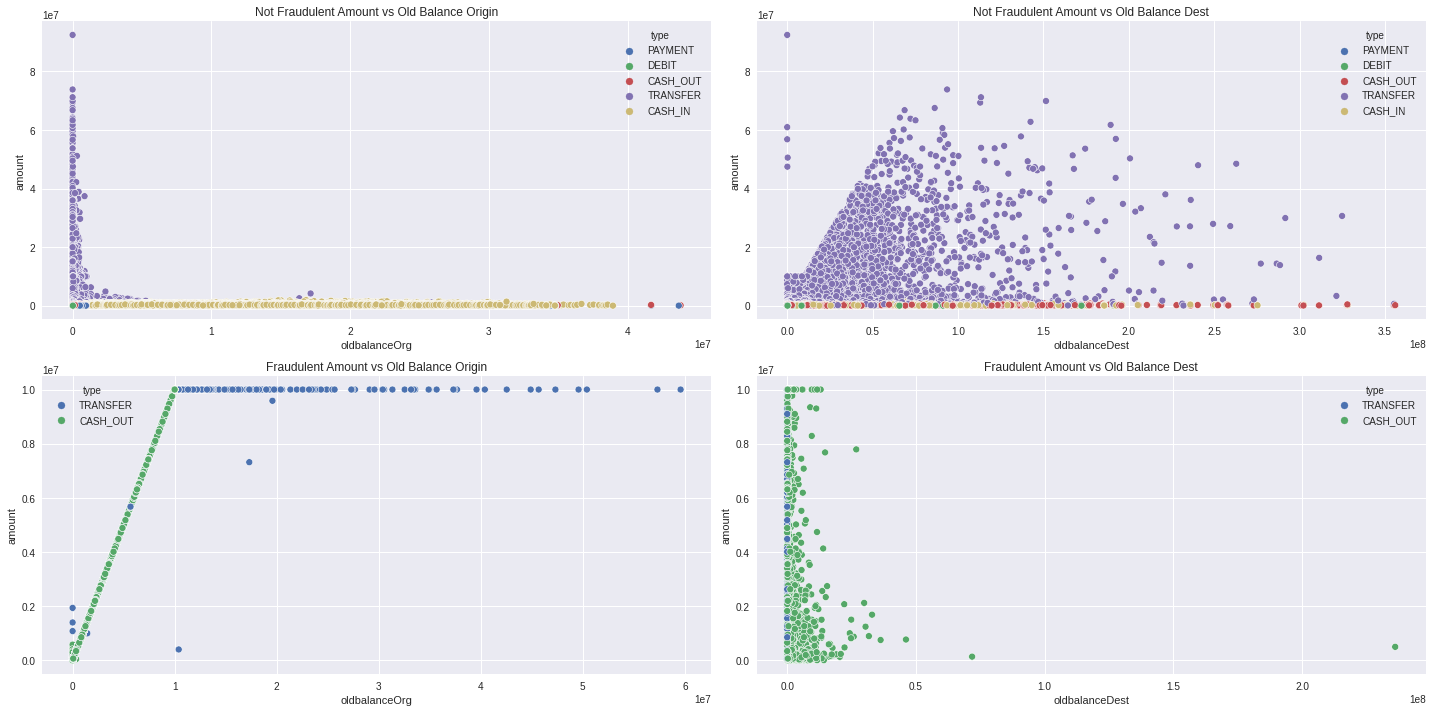

In [23]:
fig, axes = plt.subplots(2,2,figsize=(20,10)) 

sns.scatterplot(data = df_normal, ax=axes[0][0], x = 'oldbalanceOrg', y='amount', hue='type')
axes[0][0].set_title('Not Fraudulent Amount vs Old Balance Origin')

sns.scatterplot(data = df_normal, ax=axes[0][1], x = 'oldbalanceDest', y='amount', hue='type')
axes[0][1].set_title('Not Fraudulent Amount vs Old Balance Dest')

sns.scatterplot(data = df_frauds, ax=axes[1][0], x = 'oldbalanceOrg', y='amount', hue='type')
axes[1][0].set_title('Fraudulent Amount vs Old Balance Origin')

sns.scatterplot(data = df_frauds, ax=axes[1][1], x = 'oldbalanceDest', y='amount', hue='type')
axes[1][1].set_title('Fraudulent Amount vs Old Balance Dest')

plt.tight_layout()
plt.show()   

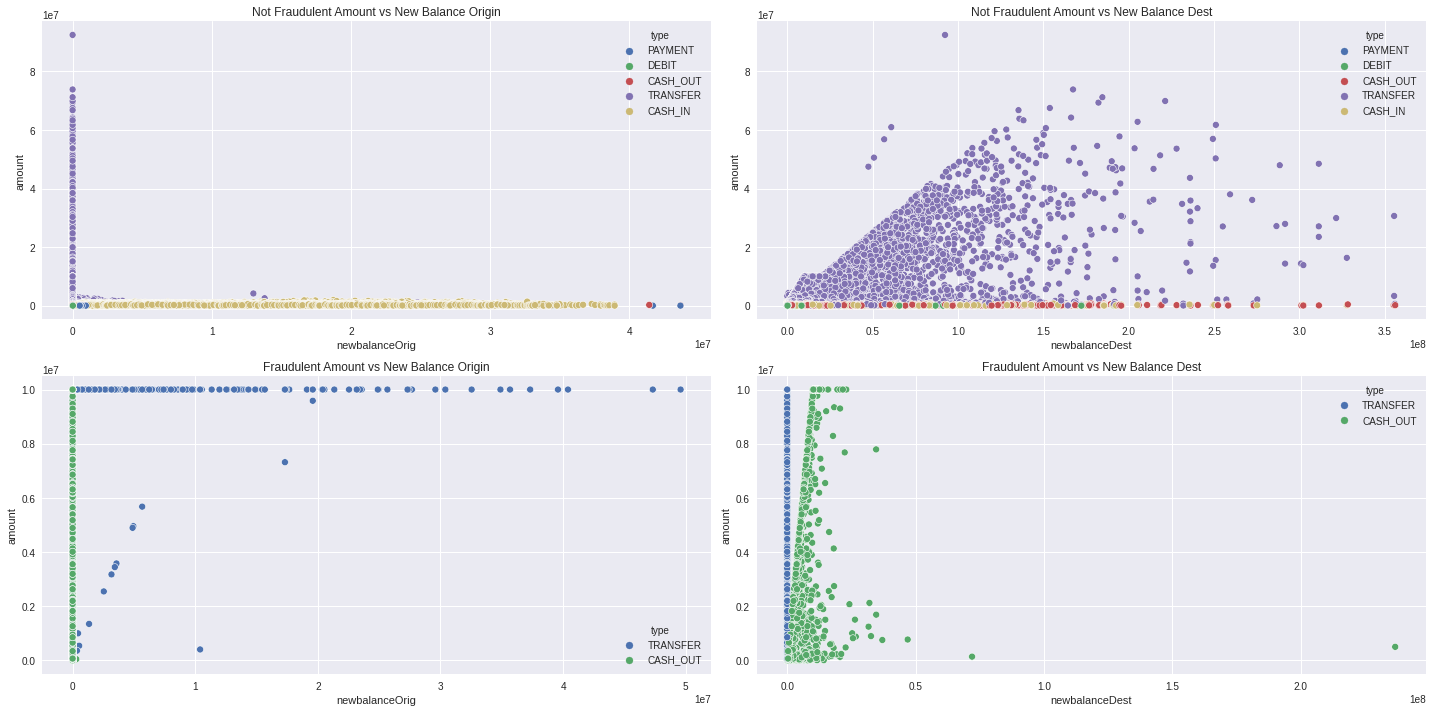

In [24]:
fig, axes = plt.subplots(2,2,figsize=(20,10)) 

sns.scatterplot(data = df_normal, ax=axes[0][0], x = 'newbalanceOrig', y='amount', hue='type')
axes[0][0].set_title('Not Fraudulent Amount vs New Balance Origin')

sns.scatterplot(data = df_normal, ax=axes[0][1], x = 'newbalanceDest', y='amount', hue='type')
axes[0][1].set_title('Not Fraudulent Amount vs New Balance Dest')

sns.scatterplot(data = df_frauds, ax=axes[1][0], x = 'newbalanceOrig', y='amount', hue='type')
axes[1][0].set_title('Fraudulent Amount vs New Balance Origin')

sns.scatterplot(data = df_frauds, ax=axes[1][1], x = 'newbalanceDest', y='amount', hue='type')
axes[1][1].set_title('Fraudulent Amount vs New Balance Dest')

plt.tight_layout()
plt.show()   

Vemos que o SaldoInicialDeOrigem parece ter uma relação bem definida com o valor em casos de fraude, em que para contas que tenham mais de 10.000.000 este é o valor transferido e para contas com menor valor em geral o valor disponível é transferido.

Em casos de fraude, para contas destino com maior saldo geralmente a fraude é através de saques, enquanto saldos menores geralmente recebem via transferência.

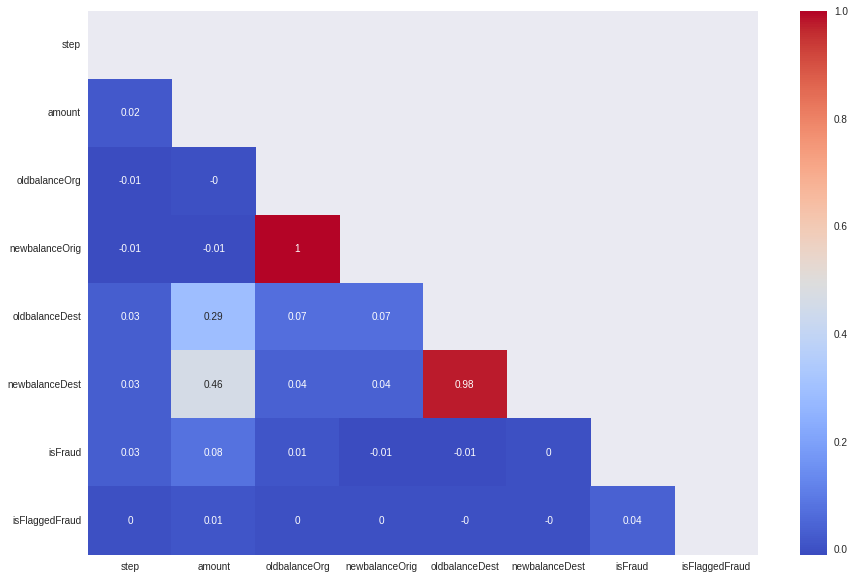

In [26]:
corr = df.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm')
plt.show()

O saldo de inicial e final é muito correlacinado, tanto para contas de origem quanto contas destino, enquanto para as demais features existem poucas relações.

### Feature Engeneering

In [27]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1,0
4,1,PAYMENT,11668.14000,C2048537720,41554.00000,29885.86000,M1230701703,0.00000,0.00000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13000,C786484425,339682.13000,0.00000,C776919290,0.00000,339682.13000,1,0
6362616,743,TRANSFER,6311409.28000,C1529008245,6311409.28000,0.00000,C1881841831,0.00000,0.00000,1,0
6362617,743,CASH_OUT,6311409.28000,C1162922333,6311409.28000,0.00000,C1365125890,68488.84000,6379898.11000,1,0
6362618,743,TRANSFER,850002.52000,C1685995037,850002.52000,0.00000,C2080388513,0.00000,0.00000,1,0


Uma vez que a informação do step representa 1 hora, podemos criar novas features, como o dia do mês e o horário do dia em que aconteceu a transação.

In [28]:
df['day'] = (df['step']//24)+1

In [29]:
df['hour'] = (df['step']) - (df['day']-1)*24

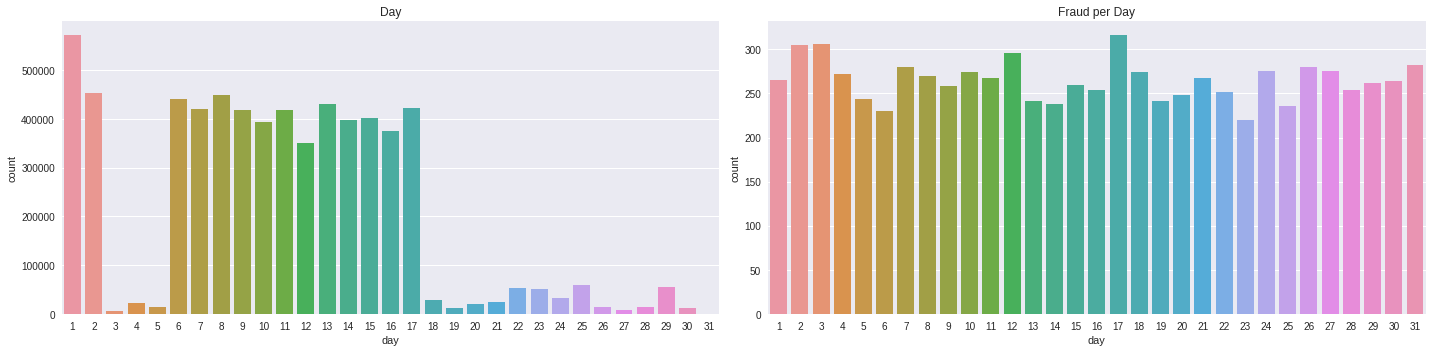

In [31]:
fig, axes = plt.subplots(1,2,figsize=(20,5)) 

sns.countplot(data = df, ax=axes[0], x = 'day')
axes[0].set_title('Day')

sns.countplot(data = df[df['isFraud']==1], ax=axes[1], x='day')
axes[1].set_title('Fraud per Day')

plt.tight_layout()
plt.show()  

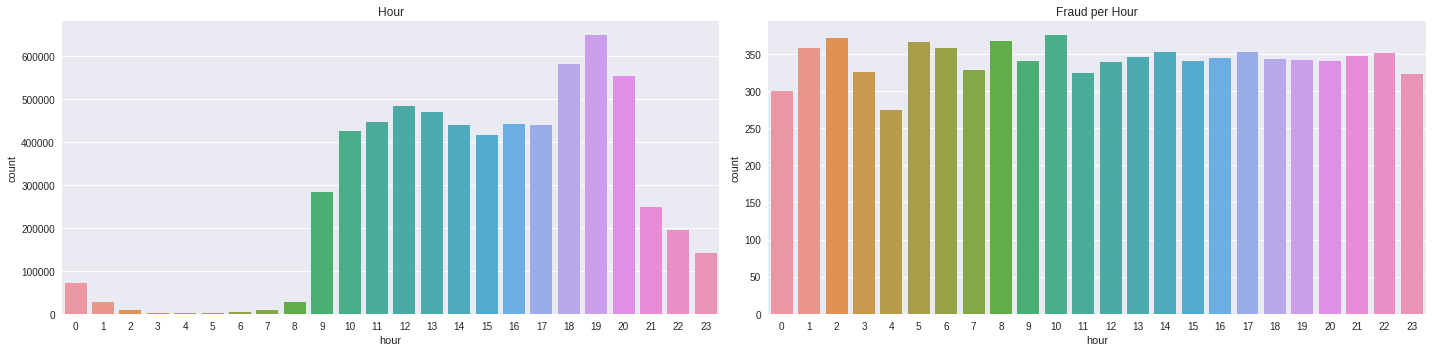

In [32]:
fig, axes = plt.subplots(1,2,figsize=(20,5)) 

sns.countplot(data = df, ax=axes[0], x = 'hour')
axes[0].set_title('Hour')

sns.countplot(data = df[df['isFraud']==1], ax=axes[1], x='hour')
axes[1].set_title('Fraud per Hour')

plt.tight_layout()
plt.show()  

É interessante observar que existe uma concentração de transação os dois primeiros dias e também entre o dia 6 e 17.

Da mesma forma, existe uma maior concentração de transações entre as 9h e 20h, o que é condizente com o que se espera.

No entanto, a mesma tendência não é observada nas fraudes, sendo realizadas de forma distribuida ao longo do mes e ao longo do dia. Assim, temos dias e horários em que a concentração de transações é maior, o que podem ser informações interessantes para a modelagem, assim, usaremos Dia e Hora ao invés do Step.

Iremos também retirar a feature isFlaggedFraud, já que ela é pouco representativa dos dados fraudulentos e já é observada pelo banco.

In [33]:
df.drop('step', axis=1, inplace=True)

In [34]:
df.drop('isFlaggedFraud', axis=1, inplace=True)

Nosso modelo deve ser capaz de identificar contas diferentes, mesmo dentre contas que ele nunca viu até o momento, portanto, o labelencoding das contas será feito antes do split.

In [35]:
label_encoder = LabelEncoder()

df['nameOrig_encode'] = label_encoder.fit_transform(df['nameOrig']) 
df['nameDest_encode'] = label_encoder.fit_transform(df['nameDest'])

df.drop(columns=['nameDest', 'nameOrig'], inplace=True)

O mesmo vale para a variável 'type', visto que existirão todos os tipos tanto no treino quanto teste.

In [36]:
df = pd.get_dummies(df, columns=["type"], prefix=["type_"])

In [37]:
df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,day,hour,nameOrig_encode,nameDest_encode,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
0,9839.64000,170136.00000,160296.36000,0.00000,0.00000,0,1,1,757869,1662094,0,0,0,1,0
1,1864.28000,21249.00000,19384.72000,0.00000,0.00000,0,1,1,2188998,1733924,0,0,0,1,0
2,181.00000,181.00000,0.00000,0.00000,0.00000,1,1,1,1002156,439685,0,0,0,0,1
3,181.00000,181.00000,0.00000,21182.00000,0.00000,1,1,1,5828262,391696,0,1,0,0,0
4,11668.14000,41554.00000,29885.86000,0.00000,0.00000,0,1,1,3445981,828919,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13000,339682.13000,0.00000,0.00000,339682.13000,1,31,23,5651847,505863,0,1,0,0,0
6362616,6311409.28000,6311409.28000,0.00000,0.00000,0.00000,1,31,23,1737278,260949,0,0,0,0,1
6362617,6311409.28000,6311409.28000,0.00000,68488.84000,6379898.11000,1,31,23,533958,108224,0,1,0,0,0
6362618,850002.52000,850002.52000,0.00000,0.00000,0.00000,1,31,23,2252932,319713,0,0,0,0,1


In [38]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    stratify=y,
                                                    random_state = 42)

In [40]:
X_train

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,day,hour,nameOrig_encode,nameDest_encode,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
1135722,246135.47000,15225.00000,0.00000,42751.95000,288887.41000,6,11,5835453,292876,0,1,0,0,0
1437333,99142.78000,0.00000,0.00000,254665.08000,353807.87000,6,20,778787,383260,0,1,0,0,0
2257519,5511.97000,166301.00000,171812.97000,104883.65000,99371.67000,8,19,947217,306845,1,0,0,0,0
5806166,506531.11000,107664.00000,614195.11000,4505008.95000,3998477.85000,17,17,2902635,215982,1,0,0,0,0
5455877,83717.62000,78209.00000,0.00000,0.00000,83717.62000,16,19,5203954,80400,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422253,175520.68000,977.00000,0.00000,91159.52000,266680.20000,6,19,1166733,298990,0,0,0,0,1
5834821,347110.99000,103785.00000,0.00000,87871.75000,434982.74000,17,18,5657454,228205,0,1,0,0,0
4182953,13259.63000,0.00000,0.00000,0.00000,0.00000,13,16,4857521,1891786,0,0,0,1,0
3985280,24122.92000,0.00000,0.00000,0.00000,0.00000,13,10,2732082,997852,0,0,0,1,0


Além do valor da transação, iremos também criar uma categorização, dividindo as transações entre valores extremamente baixos, baixos, moderados, altos e extremamente altos, utilizando os quartils e interquartil do dado de treino para a categorização.

In [41]:
Q1 = X_train['amount'].quantile(0.25)
Q2 = X_train['amount'].quantile(0.5) 
Q3 = X_train['amount'].quantile(0.75) 
Qmax = Q3 + (Q3-Q1)*1.5

In [42]:
def amount_category(x):
    if x >= Qmax:
        return('EXTREMLY HIGH')
    elif x < Qmax and x >= Q3:
        return('HIGH')
    elif x < Q3 and x >= Q2:
        return('MODERATE')
    elif x < Q2 and x >= Q1:
        return('LOW')
    elif x < Q1:
        return('EXTREMLY LOW')
X_train['amount_category'] = X_train['amount'].apply(amount_category)  
X_test['amount_category'] = X_test['amount'].apply(amount_category)

In [43]:
X_train

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,day,hour,nameOrig_encode,nameDest_encode,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER,amount_category
1135722,246135.47000,15225.00000,0.00000,42751.95000,288887.41000,6,11,5835453,292876,0,1,0,0,0,HIGH
1437333,99142.78000,0.00000,0.00000,254665.08000,353807.87000,6,20,778787,383260,0,1,0,0,0,MODERATE
2257519,5511.97000,166301.00000,171812.97000,104883.65000,99371.67000,8,19,947217,306845,1,0,0,0,0,EXTREMLY LOW
5806166,506531.11000,107664.00000,614195.11000,4505008.95000,3998477.85000,17,17,2902635,215982,1,0,0,0,0,EXTREMLY HIGH
5455877,83717.62000,78209.00000,0.00000,0.00000,83717.62000,16,19,5203954,80400,0,1,0,0,0,MODERATE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422253,175520.68000,977.00000,0.00000,91159.52000,266680.20000,6,19,1166733,298990,0,0,0,0,1,MODERATE
5834821,347110.99000,103785.00000,0.00000,87871.75000,434982.74000,17,18,5657454,228205,0,1,0,0,0,HIGH
4182953,13259.63000,0.00000,0.00000,0.00000,0.00000,13,16,4857521,1891786,0,0,0,1,0,EXTREMLY LOW
3985280,24122.92000,0.00000,0.00000,0.00000,0.00000,13,10,2732082,997852,0,0,0,1,0,LOW


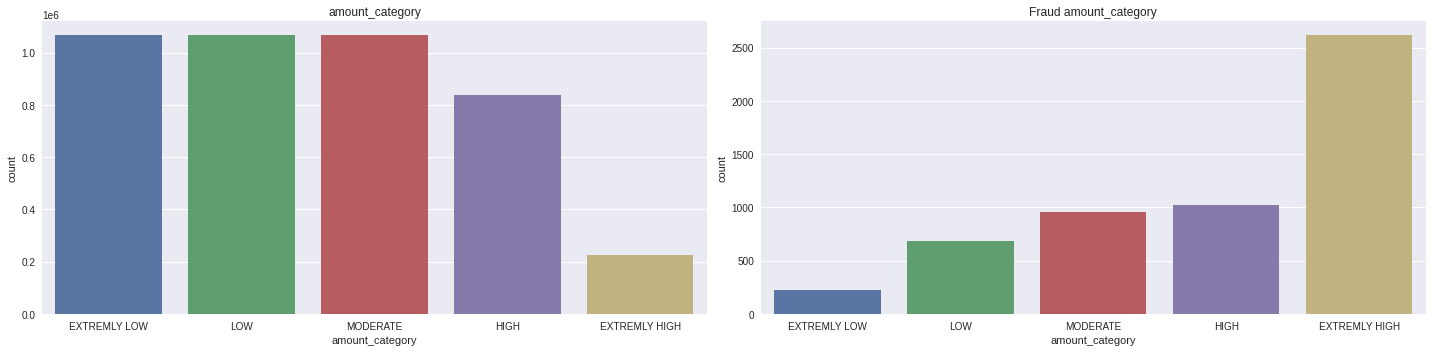

In [44]:
fig, axes = plt.subplots(1,2,figsize=(20,5)) 

sns.countplot(data = X_train, ax=axes[0], x = 'amount_category', 
              order = ['EXTREMLY LOW', 'LOW', 'MODERATE', 'HIGH', 'EXTREMLY HIGH'])
axes[0].set_title('amount_category')

sns.countplot(data = X_train[y_train==1], ax=axes[1], x='amount_category', 
              order = ['EXTREMLY LOW', 'LOW', 'MODERATE', 'HIGH', 'EXTREMLY HIGH'])
axes[1].set_title('Fraud amount_category')

plt.tight_layout()
plt.show()   

Podemos observar que claramente existe uma relação inversa entre os dados gerais e os dados fraudulentos, em que as fraudulentas se concentram ao redor nos valores extremamente altos.

Iremos realizar um ordinal encoding nesta variável, assim como normalizar as variáveis de saldo e de valor da transação.

In [45]:
X_train['amount_category'] = X_train['amount_category'].replace({'EXTREMLY LOW':1, 
                                                                       'LOW':2, 
                                                                       'MODERATE':3, 
                                                                       'HIGH':4, 
                                                                       'EXTREMLY HIGH':5})
X_test['amount_category'] = X_test['amount_category'].replace({'EXTREMLY LOW':1, 
                                                                       'LOW':2, 
                                                                       'MODERATE':3, 
                                                                       'HIGH':4, 
                                                                       'EXTREMLY HIGH':5})

In [46]:
normalizer = Normalizer()

In [47]:
X_train[['amount', 
              'oldbalanceOrg', 
              'newbalanceOrig', 
              'oldbalanceDest', 
              'newbalanceDest']] = normalizer.fit_transform(X_train[['amount', 
                                                                          'oldbalanceOrg', 
                                                                          'newbalanceOrig', 
                                                                          'oldbalanceDest', 
                                                                          'newbalanceDest']])
X_test[['amount', 
              'oldbalanceOrg', 
              'newbalanceOrig', 
              'oldbalanceDest', 
              'newbalanceDest']] = normalizer.transform(X_test[['amount', 
                                                                'oldbalanceOrg', 
                                                                'newbalanceOrig', 
                                                                'oldbalanceDest', 
                                                                'newbalanceDest']])

In [48]:
X_train

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,day,hour,nameOrig_encode,nameDest_encode,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER,amount_category
1135722,0.64395,0.03983,0.00000,0.11185,0.75580,6,11,5835453,292876,0,1,0,0,0,4
1437333,0.22177,0.00000,0.00000,0.56964,0.79141,6,20,778787,383260,0,1,0,0,0,3
2257519,0.01973,0.59514,0.61487,0.37535,0.35562,8,19,947217,306845,1,0,0,0,0,1
5806166,0.08335,0.01772,0.10107,0.74134,0.65798,17,17,2902635,215982,1,0,0,0,0,5
5455877,0.59000,0.55118,0.00000,0.00000,0.59000,16,19,5203954,80400,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422253,0.52865,0.00294,0.00000,0.27456,0.80321,6,19,1166733,298990,0,0,0,0,1,3
5834821,0.60591,0.18116,0.00000,0.15339,0.75929,17,18,5657454,228205,0,1,0,0,0,4
4182953,1.00000,0.00000,0.00000,0.00000,0.00000,13,16,4857521,1891786,0,0,0,1,0,1
3985280,1.00000,0.00000,0.00000,0.00000,0.00000,13,10,2732082,997852,0,0,0,1,0,2


### Modelagem

In [49]:
print('Dos {} dados de treino iniciais, {} são fraudes e {} não são fraudes, uma proporção de {}'.format(len(y_train), 
                                                    y_train[y_train==1].count(), 
                                                    y_train[y_train==0].count(), 
                                                    round(y_train[y_train==1].count()/y_train[y_train==0].count(), 4)))

Dos 4262955 dados de treino iniciais, 5503 são fraudes e 4257452 não são fraudes, uma proporção de 0.0013


In [50]:
def metricas_classificação(model, y_pred, y_test):
    
    accuracy =  round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall =  round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    roc_auc = round(roc_auc_score(y_test, y_pred), 4)
    TN = confusion_matrix(y_test,y_pred)[0][0]
    FP = confusion_matrix(y_test,y_pred)[0][1]
    FN = confusion_matrix(y_test,y_pred)[1][0]
    TP = confusion_matrix(y_test,y_pred)[1][1]
    
    TN_list.append(TN)    
    FP_list.append(FP)    
    FN_list.append(FN)    
    TP_list.append(TP)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    
    print("Model: {}".format(model))
    print('\n')
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1-Score: {}".format(f1))
    print("ROC AUC: {}".format(roc_auc))
    print('\nConfusion Matrix') 
    print(confusion_matrix(y_test,y_pred))
    print('\n')
    print(classification_report(y_test,y_pred))

In [51]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
TN_list = []
FP_list = []
FN_list = []
TP_list = []

In [52]:
lrc = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(objective = 'binary:logistic', random_state=42)

**Regressão Logistica:**

In [53]:
lrc.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [54]:
y_pred = lrc.predict(X_test)

metricas_classificação(lrc, y_pred, y_test)

Model: LogisticRegression(random_state=42)


Accuracy: 0.9987
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC AUC: 0.5

Confusion Matrix
[[2096955       0]
 [   2710       0]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096955
           1       0.00      0.00      0.00      2710

    accuracy                           1.00   2099665
   macro avg       0.50      0.50      0.50   2099665
weighted avg       1.00      1.00      1.00   2099665



**KNN:**

In [55]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [56]:
y_pred = knn.predict(X_test)

metricas_classificação(knn, y_pred, y_test)

Model: KNeighborsClassifier()


Accuracy: 0.9987
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC AUC: 0.5

Confusion Matrix
[[2096955       0]
 [   2710       0]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096955
           1       0.00      0.00      0.00      2710

    accuracy                           1.00   2099665
   macro avg       0.50      0.50      0.50   2099665
weighted avg       1.00      1.00      1.00   2099665



**Decision Tree:**

In [57]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [58]:
y_pred = dtc.predict(X_test)

metricas_classificação(dtc, y_pred, y_test)

Model: DecisionTreeClassifier(random_state=42)


Accuracy: 0.9997
Precision: 0.8895
Recall: 0.8882
F1-Score: 0.8888
ROC AUC: 0.944

Confusion Matrix
[[2096656     299]
 [    303    2407]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096955
           1       0.89      0.89      0.89      2710

    accuracy                           1.00   2099665
   macro avg       0.94      0.94      0.94   2099665
weighted avg       1.00      1.00      1.00   2099665



**Random Forest:**

In [59]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [60]:
y_pred = rfc.predict(X_test)

metricas_classificação(rfc, y_pred, y_test)

Model: RandomForestClassifier(random_state=42)


Accuracy: 0.9998
Precision: 0.9927
Recall: 0.8494
F1-Score: 0.9155
ROC AUC: 0.9247

Confusion Matrix
[[2096938      17]
 [    408    2302]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096955
           1       0.99      0.85      0.92      2710

    accuracy                           1.00   2099665
   macro avg       1.00      0.92      0.96   2099665
weighted avg       1.00      1.00      1.00   2099665



**Gradient Boosting:**

In [61]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [62]:
y_pred = gbc.predict(X_test)

metricas_classificação(gbc, y_pred, y_test)

Model: GradientBoostingClassifier(random_state=42)


Accuracy: 0.9989
Precision: 0.5769
Recall: 0.6007
F1-Score: 0.5886
ROC AUC: 0.8001

Confusion Matrix
[[2095761    1194]
 [   1082    1628]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096955
           1       0.58      0.60      0.59      2710

    accuracy                           1.00   2099665
   macro avg       0.79      0.80      0.79   2099665
weighted avg       1.00      1.00      1.00   2099665



In [64]:
baseline_results=pd.DataFrame(list(zip(TN_list, FP_list, FN_list, TP_list, accuracy_list, precision_list, 
                                       recall_list, f1_list, roc_auc_list)),
                              columns=['TN', 'FP', 'FN', 'TP', 'Accuracy','Precision','Recall','F1 Score','ROC AUC'],
                              index=['Baseline Logistic Regression', 
                                     'Baseline KNN', 
                                     'Baseline Decision Tree',
                                     'Baseline Random Forest',
                                     'Baseline Gradient Boosting'])

In [65]:
baseline_results

,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score,ROC AUC
Baseline Logistic Regression,2096955,0,2710,0,0.99870,0.00000,0.00000,0.00000,0.50000
Baseline KNN,2096955,0,2710,0,0.99870,0.00000,0.00000,0.00000,0.50000
Baseline Decision Tree,2096656,299,303,2407,0.99970,0.88950,0.88820,0.88880,0.94400
Baseline Random Forest,2096938,17,408,2302,0.99980,0.99270,0.84940,0.91550,0.92470
Baseline Gradient Boosting,2095761,1194,1082,1628,0.99890,0.57690,0.60070,0.58860,0.80010


Os modelos Logistic Regression e KNN não foram capazes de identificar nenhuma fraude, obtendo um AUC de 0.5, e zerando a precisão, recall e F1 score, mas mesmo assim obtiveram acurácia de 99.8%, o que deixa evidente que a acurácia não é uma boa métrica para ser utilizada.

Os demais modelos foram capazes de detectar fraudes, com um destaque para Ramdom Forest, com um F1 Score de 91.55% e recall de 84,94%.

*Movendo o Threshold do modelo Ramdom Forest:*

In [66]:
y_proba = rfc.predict_proba(X_test)

In [72]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
TN_list = []
FP_list = []
FN_list = []
TP_list = []

In [68]:
def calculate_far_frr (y_proba , y_true, n_points =30, normalize =False, threshold =None, ylimit=1000):
    thr = np.linspace( 0, 1, n_points)
    far = []
    frr = []
    
    for t in thr:
        far_pt = y_proba[y_true == 0][:,1] >= t
        frr_pt = y_proba[y_true == 1][:,1] < t
        if normalize:
            far.append(far_pt.mean())
            frr.append(frr_pt.mean())
        else:
            far.append(far_pt.sum())
            frr.append(frr_pt.sum())
    if threshold is None:
        far = np.array(far)
        frr = np.array(frr)
        optm = thr[ abs(far - frr).argmin()]
    else:
        optm = threshold
    
    plot_data = pd.DataFrame(
        index=thr,
        data={
            'far': far,
            'frr': frr},
        dtype = float)
    
    plt.figure()
    sns.lineplot(data = plot_data, x=thr, y='far')
    sns.lineplot(data = plot_data, x=thr, y='frr')
    plt.title('FAR / FRR')
    plt.xlabel('Threshold')
    plt.ylabel('Mispredicted')
    plt.axvline(x = optm, color = 'r', linestyle = '--')
    plt.legend(['FAR', 'FRR', 'Threshold'])    
    plt.ylim([0, ylimit])
    
    return optm

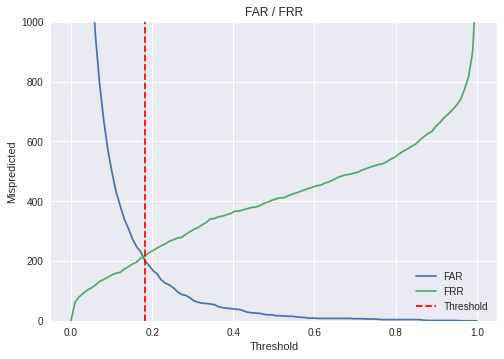

In [69]:
thresh = calculate_far_frr (y_proba , y_test, n_points =100, normalize =False, threshold =None, ylimit = 1000)

In [70]:
y_pred = rfc.predict(X_test)

for i in range(len(y_pred)):
    if y_proba[i,1]>=thresh:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

metricas_classificação(rfc, y_pred, y_test)

Model: RandomForestClassifier(random_state=42)


Accuracy: 0.9998
Precision: 0.9251
Recall: 0.9207
F1-Score: 0.9229
ROC AUC: 0.9603

Confusion Matrix
[[2096753     202]
 [    215    2495]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096955
           1       0.93      0.92      0.92      2710

    accuracy                           1.00   2099665
   macro avg       0.96      0.96      0.96   2099665
weighted avg       1.00      1.00      1.00   2099665



O Random Forest foi capaz de obter uma excelente precisão no geral dos modelos, sendo aquele que minimizou o número de falsos positivos sem resultar numa enorme perda de fraudes. Ele obteve bons resultados de AUC, F1 Score, Recall e Precisão após mudança de Threshold.

A solução ideal é aquela que melhor atende a instituição, sendo fundamental um entendimento com o time de negócios de qual o objetivo, podendo modelar a fim de se maximar ou balancear a performance de acordo com a necessidade, podendo ser a com o maior AUC, a com o maior número de detecção de fraudes ou mesmo com menor número de falsos positivos.

O projeto não necessitou uma limpeza dos dados, mas um pré processamento e Feature Engineering se mostraram eficientes para uma boa modelagem.

Um próximo passo possível seria achar os melhores hiperparâmetros para o RandomForest, além de testar também o modelo XGBoost, o que precisaria de um ótimo desempenho computacional.

Além disso, outras variáveis que não estavam presentes no dataset poderiam ser interessantes, caso estivessem disponíveis, como a renda do responsável pela conta, ou principalmente dados históricos para além de um mês. Como a simulação representava apenas 30 dias de transações, não existe um histórico extenso de transações usualmente realizadas pelo usuário, fator que poderia impulsionar a performance dos modelos.